In [25]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

llm=ChatOpenAI(model='gpt-5-nano-2025-08-07')

In [26]:
res=llm.invoke(input="test")
print(res.content)

Test received. I’m here and ready to help. What would you like to do? A few quick options:

- Answer questions or explain concepts
- Draft or edit text (emails, essays, stories)
- Translate or summarize content
- Help with code or debugging
- Brainstorm ideas or plan a project

If you want, try asking me to define a term or convert a value.


In [27]:
from typing_extensions import TypedDict, Annotated
import operator
class State(TypedDict):
    question: str
    answer: str 
    context: Annotated[list, operator.add]

In [35]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_tavily import TavilySearch

def search_web(state):
    """
    Retreive docs from web search
    """
    travily_search=TavilySearch(max_results=3)
    data=travily_search.invoke({"query": state['question']})
    search_doc=data.get("results", data)
    
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_doc
        ]
    )
    return {"context":[formatted_search_docs]}

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [38]:
def generate_answer(state):
    """
    Node to answer a question
    """
    context=state["context"]
    question=state["question"]
    template="""Answer the question {question} using this context : {context}"""
    instructions=template.format(question=question,
                                 context=context)
    answer= llm.invoke([SystemMessage(content=instructions)] + 
                       [HumanMessage(content=f"Answer the queston")])
    
    return {"answer":answer}
    

In [51]:
from langgraph.graph import StateGraph, START, END 

builder=StateGraph(State)

builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("search_web", search_web)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_web", "generate_answer" )
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

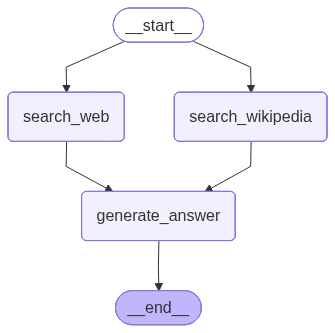

In [52]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
resultat=graph.invoke({"question":"How are Q4 nvidia earning ? "})
print(resultat['answer'].content)

Nvidia’s Q4 fiscal 2026 earnings are expected to be very strong according to the provided context.

- Revenue (consensus): about $65 billion to $65.6 billion
- Earnings per share (EPS, consensus): around $1.52
- Key driver: Data Center end-market, with projected revenue ~ $58.7 billion
- Other support: Gaming and Professional Visualization end-markets also positive
- Report date: February 25, after market close

Note: these are consensus estimates and actual results may differ.
